In [1]:
import os
import re
import pandas as pd
import nilearn as nl
import numpy as np
import seaborn as sns
from nilearn.input_data import NiftiMasker
from nilearn.image.image import mean_img
from nilearn import plotting, image
from nilearn.plotting import view_img
import warnings
warnings.filterwarnings("ignore")
from nilearn.image import math_img
import time
import multiprocessing
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'


/opt/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
project_dir='/data/projects/rf1-mbme-pilot'
subs=pd.read_csv('../derivatives/exclusions.csv')
print("We collected and downloaded data from %s subjects"%(len(subs['sub'].unique())))
GoodSubs=subs.groupby(by='sub').sum()
#print(GoodSubs.columns)
GoodSubs=GoodSubs[
    (GoodSubs['FD_exclusion']<=2)&(
        GoodSubs['ABS_exclusion']<=1)&(
        GoodSubs['Beh_TrialExclusion']<=2)].reset_index()
subs=subs[subs['sub'].isin(GoodSubs['sub'].values)].sort_values(by='sub')
subs.reset_index(inplace=True)

HC=[]
for index, row in subs.iterrows():
    if row['acq'] in ['mb1me4','mb3me4','mb6me4']:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_echo-1_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    else:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    #print(fname)
    f = open(fname)
    data = json.load(f)
    HC.append(data['ReceiveCoilName'])
    f.close()
subs['HeadCoil']=HC
subs['MB'] =  [int(re.search('mb(.*)me',str(x)).group(1)) for x in subs['acq']]
subs['ME'] =  [int(re.search('me(.*)',str(x)).group(1)) for x in subs['acq']]

print(" There are %s number of subjects who passed the exclusion criteria."%(len(subs['sub'].unique())))
print(" %s Were collected using a 64 channel headcoil and %s with a 20 channel headcoil"%(len(subs[subs['HeadCoil']=='HeadNeck_64']['sub'].unique()),
                                                                                          len(subs[subs['HeadCoil']=='HeadNeck_20']['sub'].unique())))
  

We collected and downloaded data from 43 subjects
 There are 32 number of subjects who passed the exclusion criteria.
 19 Were collected using a 64 channel headcoil and 13 with a 20 channel headcoil


# Count Subjects with full L1 output

In [3]:
act=[]
ppi=[]
L2ppi=[]
for index,row in subs.iterrows():
    sub=row['sub']
    acq=row['acq']
    act.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,acq)))
    ppi.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,acq)))
    L2ppi.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L2_task-sharedreward_model-1_type-ppi_seed-VS_thr5_sm-4.gfeat/cope10.feat/stats/cope1.nii.gz'%(sub)))

subs['L1act']=act
subs['L1ppi']=ppi
subs['L2ppi']=L2ppi
#display(subs)
subs[subs['L2ppi']==False].head()

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi,L2ppi
102,249,sub-10185,mb6me1,2,0.777281,0.109853,False,False,False,HeadNeck_20,6,1,True,True,False
103,248,sub-10185,mb1me4,0,0.445697,0.061965,False,False,False,HeadNeck_20,1,4,True,True,False
104,247,sub-10185,mb6me4,2,0.474361,0.077345,False,False,False,HeadNeck_20,6,4,False,False,False
105,246,sub-10185,mb3me1,0,1.528850,0.128609,False,True,False,HeadNeck_20,3,1,True,True,False
106,245,sub-10185,mb3me4,1,0.624076,0.079947,False,False,False,HeadNeck_20,3,4,True,True,False


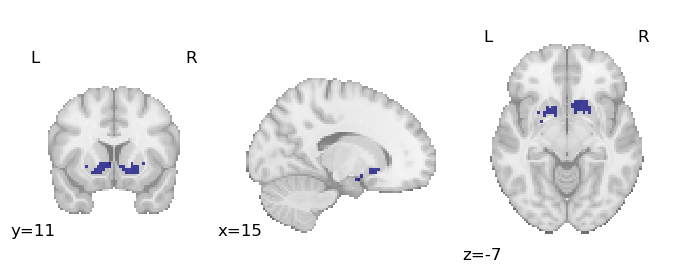

In [4]:
r_vs='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
l_vs='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
F_VS=math_img('img1+img2',img1=r_vs,img2=l_vs)
plotting.plot_roi(F_VS,draw_cross=False)
plt.savefig("../derivatives/figures/assets/mask_VS-func.svg")
plt.show()

VS


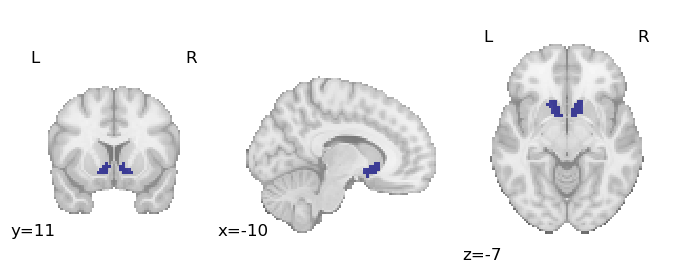

RVS


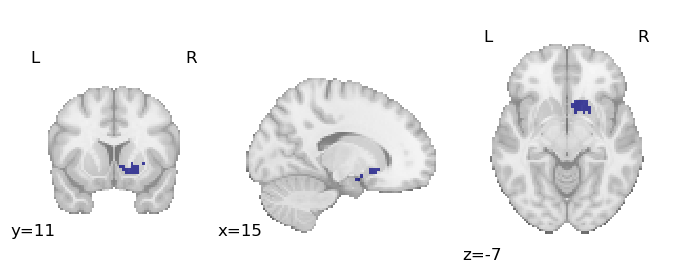

LVS


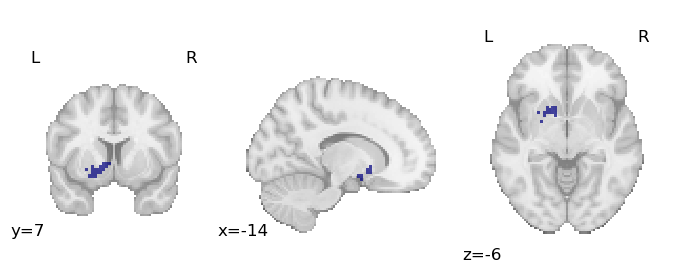

vmPFC


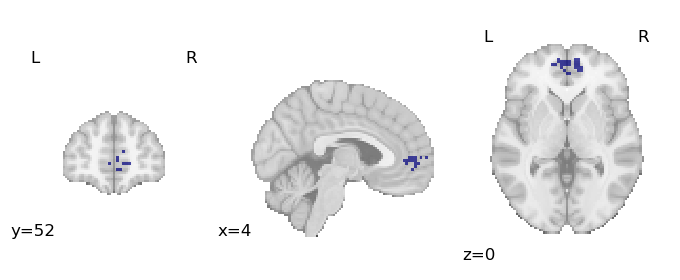

FFA


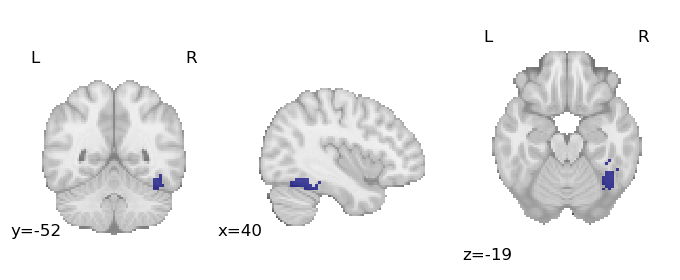

sCerb


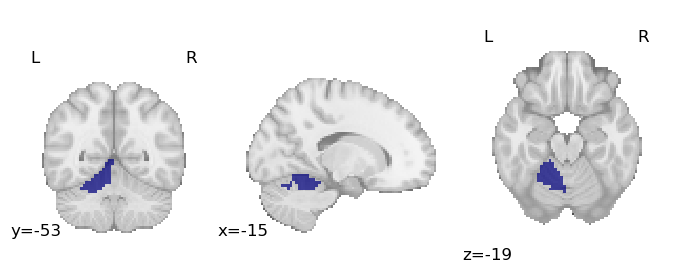

iCerb


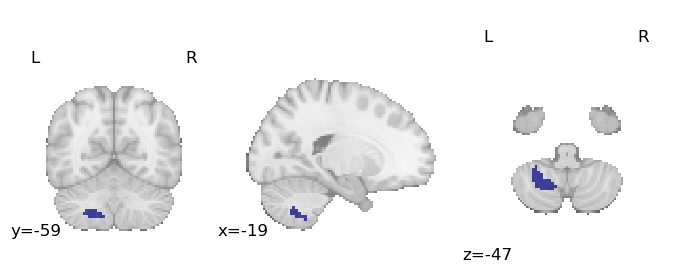

Motor


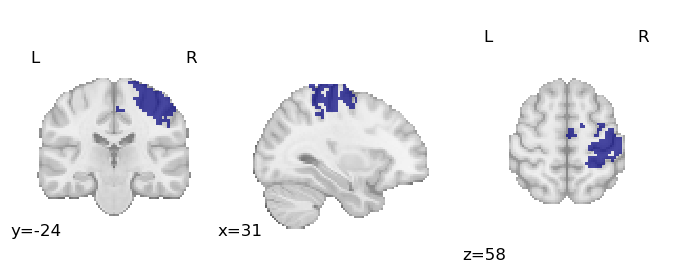

In [5]:
from nilearn import  image
#Striatum Mask
if 1==1:
    VS_mask='../masks/ROI-VS_cname-prereg.nii.gz'
    rstr_mask='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
    lstr_mask='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
    pfc_mask='../masks/fROI-vmPFC_cname-RewVsPun_zstat-1.nii.gz'
    FFA_mask='../masks/fROI-FFA_cname-StrVsComp_zstat-1.nii.gz'
    sCerb_mask='../masks/fROI-sCerb_cname-LeftVsRight_zstat-1.nii.gz'
    iCerb_mask='../masks/fROI-iCerb_cname-LeftVsRight_zstat-1.nii.gz'
    motor_mask='../masks/fROI-Motor_cname-LeftVsRight_zstat-1.nii.gz'
    mask_list=[VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]
    
    for mask in mask_list:
        str_mask=NiftiMasker(mask_img=mask)
        mask_name=re.search('ROI-(.*)_cname',mask).group(1)
        print(mask_name)
        plotting.plot_roi(mask,draw_cross=False)
        plt.savefig("../derivatives/figures/assets/mask_%s.svg"%(mask_name))
        plt.show()
mask_list=[F_VS,VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]


# VS- Reward Activiation

In [6]:
#masker= NiftiMasker(mask_img=VS_mask)
masker= NiftiMasker(mask_img=F_VS)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope13.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat13.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope13.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(VS_Reward_cope=copes,
               VS_Reward_zstats=zstats,
               VS_Reward_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [02:09<00:00,  1.47it/s]


# Display Reward Activation by Acquisition

HeadNeck_64
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: VS_Reward_zstats
No. Observations: 114     Method:             REML            
No. Groups:       19      Scale:              0.2531          
Min. group size:  6       Log-Likelihood:     -92.2474        
Max. group size:  6       Converged:          Yes             
Mean group size:  6.0                                         
----------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------
Intercept    0.182      0.175    1.042   0.297   -0.160    0.524
MB           0.093      0.045    2.081   0.037    0.005    0.180
ME           0.023      0.060    0.392   0.695   -0.094    0.141
MB:ME       -0.016      0.015   -1.069   0.285   -0.046    0.014
Group Var    0.000      0.034                                   
==============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: VS_Reward_cope
No. Observations: 114     Method:             REML          
No. Groups:       19      Scale:              27998.7534    
Min. group size:  6       Log-Likelihood:     -731.0023     
Max. group size:  6       Converged:          Yes           
Mean group size:  6.0                                       
-------------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
-------------------------------------------------------------
Intercept   91.767    58.047   1.581  0.114  -22.004  205.538
MB          11.486    14.824   0.775  0.438  -17.568   40.541
ME          15.623    19.910   0.785  0.433  -23.400   54.646
MB:ME       -4.246     5.085  -0.835  0.404  -14.212    5.719
Group Var    0.006    10.304                                 
============================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: VS_Reward_zstats
No. Observations: 69      Method:             REML            
No. Groups:       12      Scale:              0.1656          
Min. group size:  5       Log-Likelihood:     -47.2808        
Max. group size:  6       Converged:          Yes             
Mean group size:  5.8                                         
----------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------
Intercept   -0.054      0.188   -0.289   0.772   -0.422    0.314
MB           0.073      0.046    1.582   0.114   -0.018    0.164
ME           0.083      0.062    1.331   0.183   -0.039    0.205
MB:ME       -0.021      0.016   -1.311   0.190   -0.052    0.010
Group Var    0.019      0.055                                   
==============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: VS_Reward_cope
No. Observations: 69      Method:             REML          
No. Groups:       12      Scale:              26679.7599    
Min. group size:  5       Log-Likelihood:     -437.8411     
Max. group size:  6       Converged:          Yes           
Mean group size:  5.8                                       
------------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------
Intercept     -14.690   76.177 -0.193 0.847 -163.995 134.616
MB             21.418   18.590  1.152 0.249  -15.017  57.853
ME             39.619   25.036  1.582 0.114   -9.451  88.690
MB:ME          -7.726    6.397 -1.208 0.227  -20.264   4.812
Group Var    4408.739   26.098                              
============================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                MixedLM    Dependent Variable:    VS_Reward_zstats
No. Observations:     183        Method:                REML            
No. Groups:           31         Scale:                 0.2238          
Min. group size:      5          Log-Likelihood:        -141.1378       
Max. group size:      6          Converged:             Yes             
Mean group size:      5.9                                               
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.056    0.214 -0.261 0.794 -0.475  0.363
HeadCoil[T.HeadNeck_64]        0.238    0.270  0.881 0.378 -0.291  0.767
MB                             0.073    0.054  1.360 0.174 -0.032  0.179
MB:HeadCoil[T.HeadNeck_64]     0.020    0.068  0.288 0.773 -0.114  0.153
ME                             0.083    0.072  1.141 0.254 -0.059  0.225
ME:HeadCoil[T.HeadNeck_64]    -0.059    0.092 -0.645 0.519 -0.239  0.121
MB:ME                         -0.020    0.018 -1.103 0.270 -0.057  0.016
MB:ME:HeadCoil[T.HeadNeck_64]  0.004    0.023  0.173 0.862 -0.042  0.050
Group Var                      0.004    0.025                           
========================================================================

"""

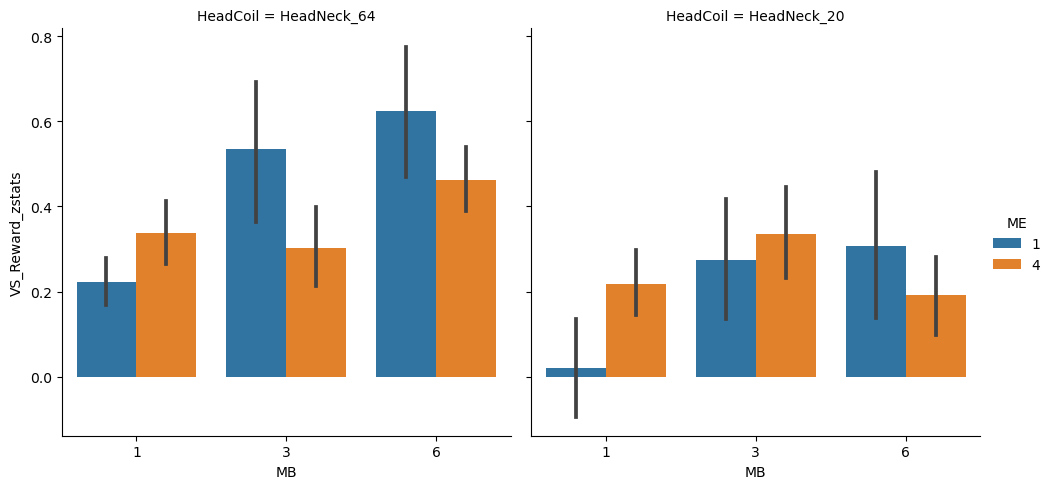

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                   MixedLM      Dependent Variable:      VS_Reward_cope
No. Observations:        183          Method:                  REML          
No. Groups:              31           Scale:                   27593.6517    
Min. group size:         5            Log-Likelihood:          -1169.5912    
Max. group size:         6            Converged:               Yes           
Mean group size:         5.9                                                 
-----------------------------------------------------------------------------
                               Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                      -15.630   75.724 -0.206 0.836 -164.047 132.786
HeadCoil[T.HeadNeck_64]        107.398   95.581  1.124 0.261  -79.938 294.733
MB                              21.438   18.890  1.135 0.256  -15.585  58.461
MB:HeadCoil[T.HeadNeck_64]      -9.952   23.946 -0.416 0.678  -56.884  36.981
ME                              39.518   25.437  1.554 0.120  -10.337  89.373
ME:HeadCoil[T.HeadNeck_64]     -23.895   32.213 -0.742 0.458  -87.032  39.242
MB:ME                           -7.543    6.499 -1.161 0.246  -20.281   5.195
MB:ME:HeadCoil[T.HeadNeck_64]    3.297    8.229  0.401 0.689  -12.831  19.426
Group Var                     1536.464   10.846                              
=============================================================================

"""

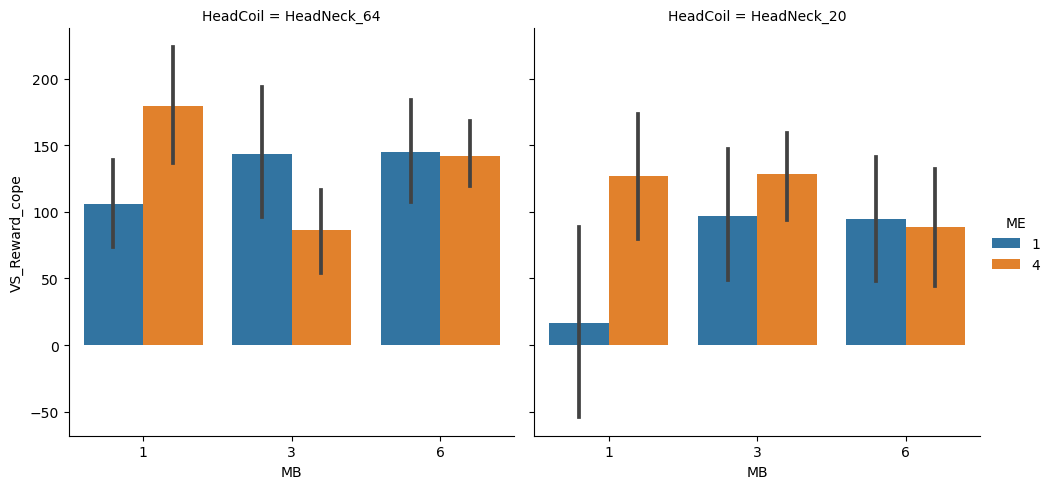

In [7]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('VS_Reward_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('VS_Reward_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('VS_Reward_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())

sns.catplot(x='MB',y='VS_Reward_zstats',hue='ME',data=plt_df,kind='bar',ci=68,
            order=[1,3,6],col='HeadCoil')

plt.savefig("../derivatives/figures/assets/Reward_VS-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('VS_Reward_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='VS_Reward_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])
plt.savefig("../derivatives/figures/assets/Reward_VS-act_cope.svg")

plt.show()

# print("Results for VarCope")
# res=smf.mixedlm('VS_Reward_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='VS_Reward_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
#plt.savefig("../derivatives/figures/assets/Reward_VS-act_varcope.svg")
#plt.show()

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi,L2ppi,VS_Reward_cope,VS_Reward_zstats,VS_Reward_varcope
0,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64,3,1,True,True,True,309.407959,1.249983,76801.156250
1,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64,6,4,True,True,True,136.362366,0.421408,88522.718750
2,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64,1,1,True,True,True,70.116760,0.230986,287302.875000
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64,3,4,True,True,True,63.179405,0.243662,96206.695312
4,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64,1,4,True,True,True,80.045624,0.253255,209722.671875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,32,sub-12042,mb3me1,0,0.882717,0.166905,False,False,False,HeadNeck_20,3,1,True,True,True,119.178452,0.348129,139635.312500
186,33,sub-12042,mb6me4,0,0.465247,0.086336,False,False,False,HeadNeck_20,6,4,True,True,True,178.331131,0.463051,192740.109375
187,34,sub-12042,mb1me4,0,0.384643,0.091856,False,False,False,HeadNeck_20,1,4,True,True,True,188.691574,0.384150,383343.500000
188,35,sub-12042,mb6me1,0,0.562190,0.120174,False,False,False,HeadNeck_20,6,1,True,True,True,54.769428,0.104857,99543.578125


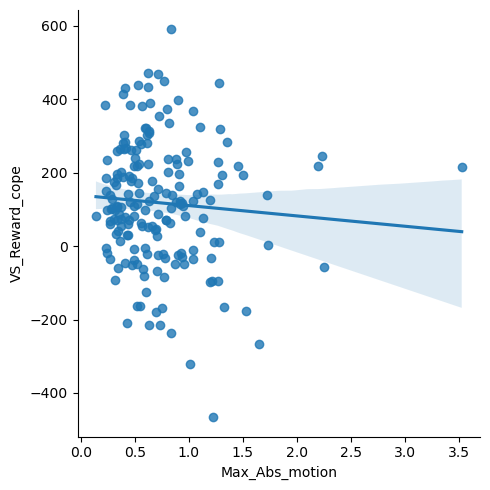

In [8]:
display(plt_df)
sns.lmplot(x='Max_Abs_motion',y='VS_Reward_cope',data=plt_df)

# FFA-Face Activiation

In [9]:
masker= NiftiMasker(mask_img=FFA_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope11.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope11.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(FFA_face_cope=copes,
               FFA_face_zstats=zstats,
               FFA_face_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [02:12<00:00,  1.43it/s]


# Display Face Activation by Acquisition (FFA)

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: FFA_face_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.3749         
Min. group size:  6       Log-Likelihood:     -125.3495      
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.422     0.232   1.821  0.069  -0.032   0.876
MB              0.061     0.054   1.128  0.259  -0.045   0.168
ME             -0.019     0.073  -0.257  0.797  -0.162   0.124
MB:ME           0.010     0.019   0.525  0.600  -0.027   0.046
Group Var       0.162     0.134                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: FFA_face_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              37006.9791   
Min. group size:  6       Log-Likelihood:     -755.0197    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     174.046   70.570  2.466 0.014  35.731 312.360
MB             -9.821   17.043 -0.576 0.564 -43.224  23.582
ME            -12.120   22.890 -0.529 0.596 -56.983  32.744
MB:ME           5.884    5.846  1.007 0.314  -5.573  17.341
Group Var   10004.118   30.641                             
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: FFA_face_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.4195         
Min. group size:  5       Log-Likelihood:     -80.2430       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.524     0.310   1.689  0.091  -0.084   1.132
MB             -0.021     0.074  -0.291  0.771  -0.166   0.123
ME             -0.035     0.099  -0.354  0.723  -0.230   0.160
MB:ME          -0.001     0.025  -0.030  0.976  -0.050   0.049
Group Var       0.127     0.142                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: FFA_face_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              64614.9362   
Min. group size:  5       Log-Likelihood:     -467.8928    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     205.863  120.676  1.706 0.088 -30.657 442.383
MB             -9.387   28.945 -0.324 0.746 -66.118  47.344
ME            -13.931   38.990 -0.357 0.721 -90.349  62.487
MB:ME          -2.280    9.959 -0.229 0.819 -21.800  17.240
Group Var   16558.795   50.603                             
===========================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    FFA_face_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.3915         
Min. group size:       5          Log-Likelihood:        -205.7310      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.525    0.304  1.729 0.084 -0.070  1.121
HeadCoil[T.HeadNeck_64]       -0.104    0.384 -0.270 0.787 -0.856  0.649
MB                            -0.022    0.071 -0.306 0.760 -0.161  0.118
MB:HeadCoil[T.HeadNeck_64]     0.083    0.090  0.919 0.358 -0.094  0.260
ME                            -0.036    0.096 -0.372 0.710 -0.224  0.152
ME:HeadCoil[T.HeadNeck_64]     0.017    0.121  0.140 0.889 -0.221  0.255
MB:ME                         -0.001    0.025 -0.025 0.980 -0.049  0.047
MB:ME:HeadCoil[T.HeadNeck_64]  0.010    0.031  0.334 0.738 -0.050  0.071
Group Var                      0.149    0.098                           
========================================================================

"""

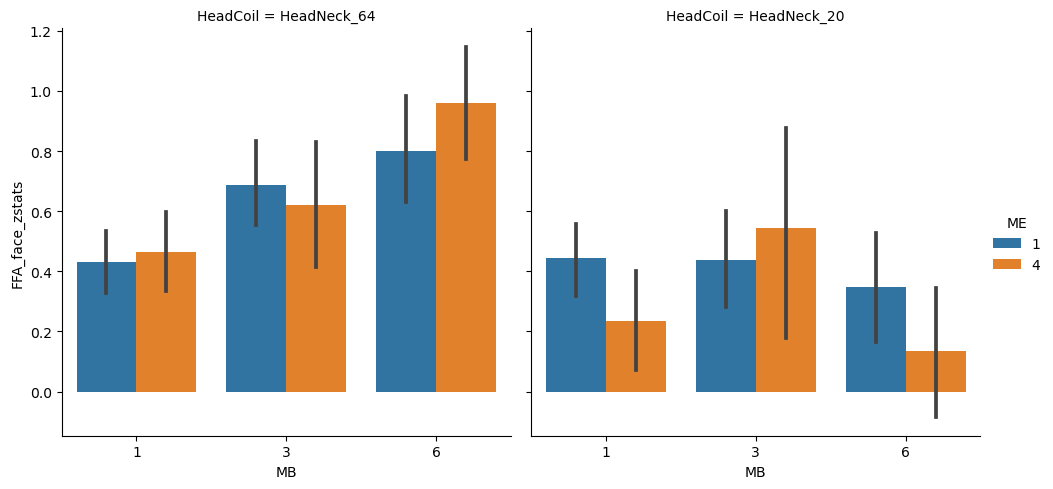

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                   MixedLM       Dependent Variable:       FFA_face_cope
No. Observations:        183           Method:                   REML         
No. Groups:              31            Scale:                    47243.2236   
Min. group size:         5             Log-Likelihood:           -1226.1379   
Max. group size:         6             Converged:                Yes          
Mean group size:         5.9                                                  
------------------------------------------------------------------------------
                                Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------
Intercept                       205.941  103.334  1.993 0.046    3.410 408.471
HeadCoil[T.HeadNeck_64]         -31.895  130.461 -0.244 0.807 -287.594 223.804
MB                               -9.406   24.749 -0.380 0.704  -57.913  39.101
MB:HeadCoil[T.HeadNeck_64]       -0.415   31.358 -0.013 0.989  -61.875  61.045
ME                              -13.964   33.336 -0.419 0.675  -79.301  51.373
ME:HeadCoil[T.HeadNeck_64]        1.844   42.192  0.044 0.965  -80.850  84.539
MB:ME                            -2.269    8.515 -0.267 0.790  -18.958  14.419
MB:ME:HeadCoil[T.HeadNeck_64]     8.154   10.776  0.757 0.449  -12.967  29.274
Group Var                     12478.961   27.016                              
==============================================================================

"""

<Figure size 640x480 with 0 Axes>

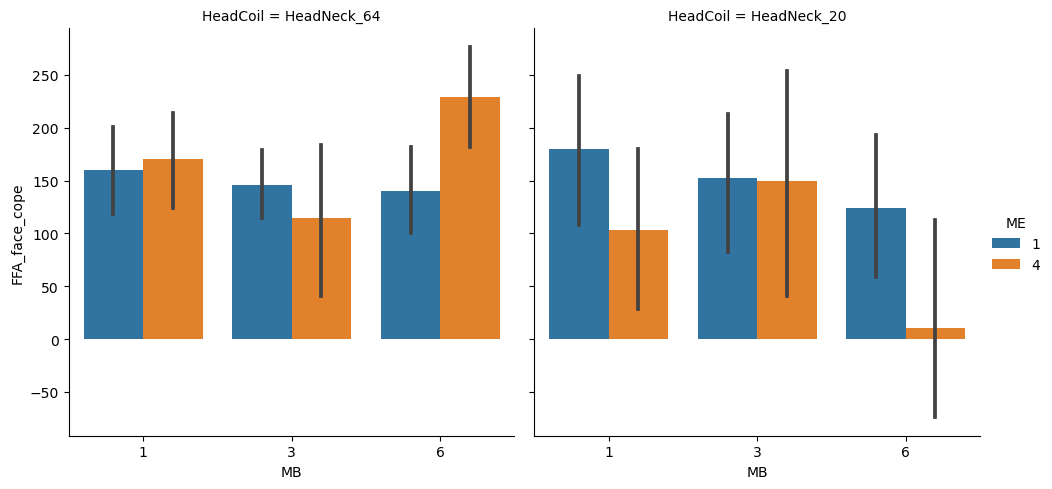

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('FFA_face_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('FFA_face_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('FFA_face_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('FFA_face_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('FFA_face_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='FFA_face_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_varcope.svg")


# Central Gyrus-Button Activiation

In [11]:
masker= NiftiMasker(mask_img=motor_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(Motor_LR_cope=copes,
               Motor_LR_zstats=zstats,
               Motor_LR_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [02:16<00:00,  1.39it/s]


# Display Motor Activation by Acquisition

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Motor_LR_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.3129         
Min. group size:  6       Log-Likelihood:     -120.9347      
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.476     0.230   2.064  0.039   0.024   0.927
MB              0.176     0.050   3.543  0.000   0.078   0.273
ME              0.036     0.067   0.548  0.584  -0.094   0.167
MB:ME          -0.022     0.017  -1.289  0.197  -0.055   0.011
Group Var       0.294     0.225                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Motor_LR_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              19445.1859   
Min. group size:  6       Log-Likelihood:     -723.8478    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     156.223   53.707  2.909 0.004  50.960 261.486
MB             12.529   12.354  1.014 0.310 -11.684  36.742
ME             21.371   16.592  1.288 0.198 -11.149  53.892
MB:ME          -5.432    4.237 -1.282 0.200 -13.737   2.873
Group Var   10341.501   35.502                             
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Motor_LR_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.3488         
Min. group size:  5       Log-Likelihood:     -76.6753       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.379     0.296   1.280  0.201  -0.202   0.960
MB              0.163     0.067   2.427  0.015   0.031   0.295
ME              0.126     0.091   1.389  0.165  -0.052   0.304
MB:ME          -0.039     0.023  -1.669  0.095  -0.084   0.007
Group Var       0.198     0.204                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Motor_LR_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              56433.3930   
Min. group size:  5       Log-Likelihood:     -464.6591    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     224.138  114.943  1.950 0.051  -1.146 449.422
MB             16.209   27.061  0.599 0.549 -36.829  69.248
ME             35.146   36.463  0.964 0.335 -36.320 106.613
MB:ME          -8.056    9.314 -0.865 0.387 -26.311  10.198
Group Var   20211.814   59.544                             
===========================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    Motor_LR_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.3262         
Min. group size:       5          Log-Likelihood:        -197.8603      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.381    0.297  1.284 0.199 -0.201  0.963
HeadCoil[T.HeadNeck_64]        0.094    0.376  0.251 0.802 -0.642  0.830
MB                             0.163    0.065  2.502 0.012  0.035  0.290
MB:HeadCoil[T.HeadNeck_64]     0.013    0.082  0.154 0.878 -0.149  0.174
ME                             0.125    0.088  1.425 0.154 -0.047  0.297
ME:HeadCoil[T.HeadNeck_64]    -0.089    0.111 -0.798 0.425 -0.306  0.129
MB:ME                         -0.038    0.022 -1.716 0.086 -0.082  0.005
MB:ME:HeadCoil[T.HeadNeck_64]  0.017    0.028  0.583 0.560 -0.039  0.072
Group Var                      0.258    0.157                           
========================================================================

"""

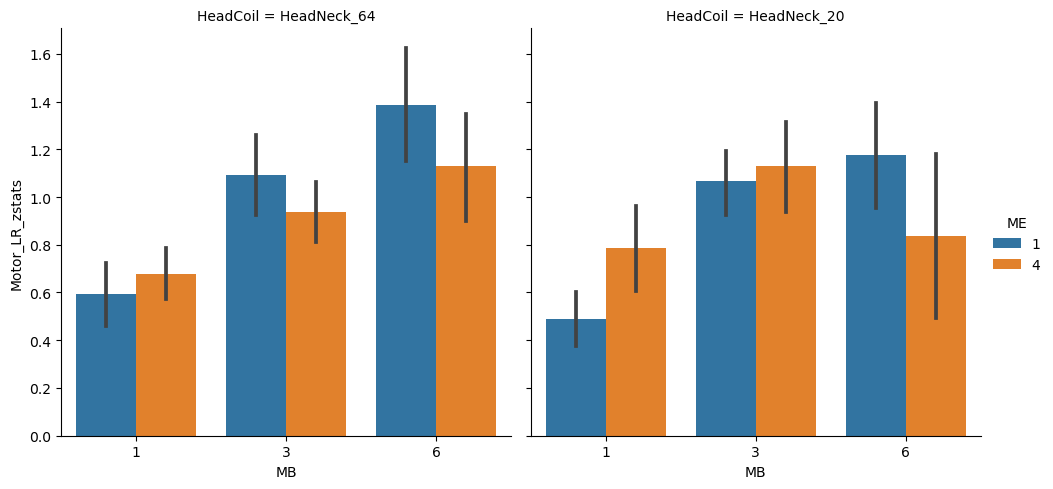

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                   MixedLM       Dependent Variable:       Motor_LR_cope
No. Observations:        183           Method:                   REML         
No. Groups:              31            Scale:                    33140.0543   
Min. group size:         5             Log-Likelihood:           -1199.7100   
Max. group size:         6             Converged:                Yes          
Mean group size:         5.9                                                  
------------------------------------------------------------------------------
                                Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------
Intercept                       224.765   89.146  2.521 0.012   50.041 399.489
HeadCoil[T.HeadNeck_64]         -68.542  112.598 -0.609 0.543 -289.231 152.147
MB                               16.060   20.737  0.774 0.439  -24.584  56.705
MB:HeadCoil[T.HeadNeck_64]       -3.531   26.271 -0.134 0.893  -55.020  47.958
ME                               34.841   27.939  1.247 0.212  -19.917  89.600
ME:HeadCoil[T.HeadNeck_64]      -13.470   35.352 -0.381 0.703  -82.758  55.819
MB:ME                            -7.970    7.136 -1.117 0.264  -21.956   6.016
MB:ME:HeadCoil[T.HeadNeck_64]     2.538    9.029  0.281 0.779  -15.158  20.234
Group Var                     14118.330   31.365                              
==============================================================================

"""

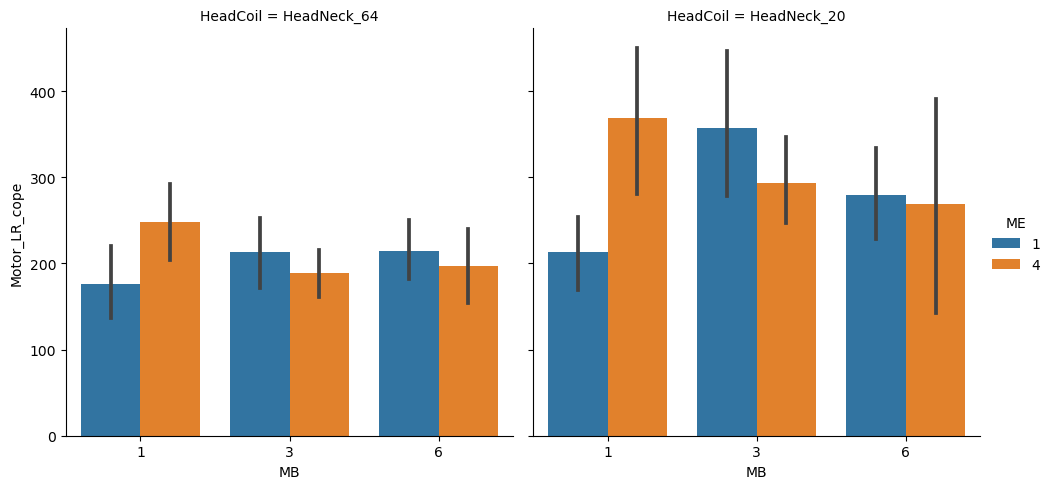

In [13]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('Motor_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('Motor_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('Motor_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/Motor_LR-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('Motor_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/Motor_LR-act_cope.svg")
plt.show()


# print("Results for VarCope")
# res=smf.mixedlm('Motor_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

#plt.savefig("../derivatives/figures/assets/Motor_LR-act_varcope.svg")
#plt.show()

# Central ICerbt-Button Activiation

In [14]:
masker= NiftiMasker(mask_img=iCerb_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(iCerb_LR_cope=copes,
               iCerb_LR_zstats=zstats,
               iCerb_LR_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [02:14<00:00,  1.42it/s]


# Display Inferior Cerebellar Activation by Acquisition

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: iCerb_LR_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.2657         
Min. group size:  6       Log-Likelihood:     -106.0804      
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.120     0.194   0.619  0.536  -0.260   0.501
MB              0.132     0.046   2.881  0.004   0.042   0.221
ME              0.042     0.061   0.690  0.490  -0.078   0.163
MB:ME          -0.012     0.016  -0.769  0.442  -0.043   0.019
Group Var       0.109     0.108                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: iCerb_LR_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              35473.3282   
Min. group size:  6       Log-Likelihood:     -755.1931    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
-----------------------------------------------------------
               Coef.   Std.Err.   z   P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept       99.965   70.959 1.409 0.159 -39.112 239.041
MB              10.213   16.686 0.612 0.540 -22.491  42.916
ME               1.424   22.411 0.064 0.949 -42.500  45.348
MB:ME            0.832    5.723 0.145 0.884 -10.386  12.049
Group Var    14556.056   39.611                            
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: iCerb_LR_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.2344         
Min. group size:  5       Log-Likelihood:     -60.6020       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept      -0.281     0.229  -1.224  0.221  -0.730   0.169
MB              0.153     0.055   2.773  0.006   0.045   0.261
ME              0.190     0.074   2.559  0.010   0.044   0.336
MB:ME          -0.044     0.019  -2.294  0.022  -0.081  -0.006
Group Var       0.057     0.094                               
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: iCerb_LR_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              38945.8315   
Min. group size:  5       Log-Likelihood:     -448.9090    
Max. group size:  6       Converged:          No           
Mean group size:  5.8                                      
-----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept    -88.113   90.788 -0.971 0.332 -266.054  89.828
MB            45.217   22.457  2.014 0.044    1.203  89.231
ME            63.878   30.251  2.112 0.035    4.587 123.169
MB:ME        -12.943    7.729 -1.675 0.094  -28.091   2.205
Group Var   3789.915   25.354                              
===========================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    iCerb_LR_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.2541         
Min. group size:       5          Log-Likelihood:        -167.1649      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.279    0.244 -1.144 0.253 -0.756  0.199
HeadCoil[T.HeadNeck_64]        0.399    0.308  1.296 0.195 -0.204  1.002
MB                             0.152    0.057  2.655 0.008  0.040  0.265
MB:HeadCoil[T.HeadNeck_64]    -0.021    0.073 -0.287 0.774 -0.163  0.122
ME                             0.189    0.077  2.447 0.014  0.038  0.341
ME:HeadCoil[T.HeadNeck_64]    -0.147    0.098 -1.501 0.133 -0.339  0.045
MB:ME                         -0.043    0.020 -2.192 0.028 -0.082 -0.005
MB:ME:HeadCoil[T.HeadNeck_64]  0.031    0.025  1.251 0.211 -0.018  0.080
Group Var                      0.089    0.075                           
========================================================================

"""

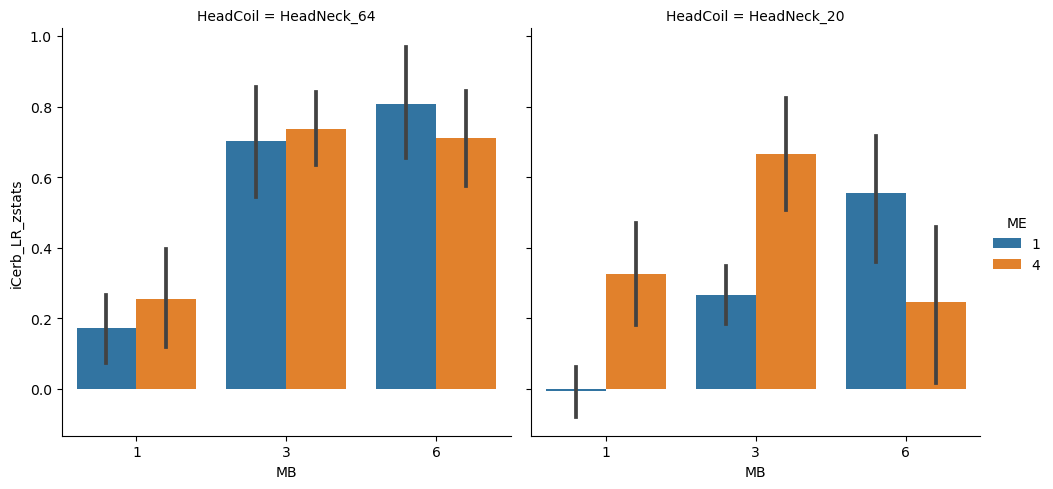

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                   MixedLM       Dependent Variable:       iCerb_LR_cope
No. Observations:        183           Method:                   REML         
No. Groups:              31            Scale:                    36807.7215   
Min. group size:         5             Log-Likelihood:           -1204.9565   
Max. group size:         6             Converged:                Yes          
Mean group size:         5.9                                                  
------------------------------------------------------------------------------
                                Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------
Intercept                       -86.142   91.555 -0.941 0.347 -265.586  93.301
HeadCoil[T.HeadNeck_64]         186.107  115.597  1.610 0.107  -40.459 412.673
MB                               44.732   21.846  2.048 0.041    1.914  87.549
MB:HeadCoil[T.HeadNeck_64]      -34.519   27.679 -1.247 0.212  -88.769  19.731
ME                               62.944   29.426  2.139 0.032    5.270 120.618
ME:HeadCoil[T.HeadNeck_64]      -61.520   37.243 -1.652 0.099 -134.514  11.475
MB:ME                           -12.659    7.516 -1.684 0.092  -27.389   2.071
MB:ME:HeadCoil[T.HeadNeck_64]    13.491    9.512  1.418 0.156   -5.152  32.133
Group Var                     10464.845   24.942                              
==============================================================================

"""

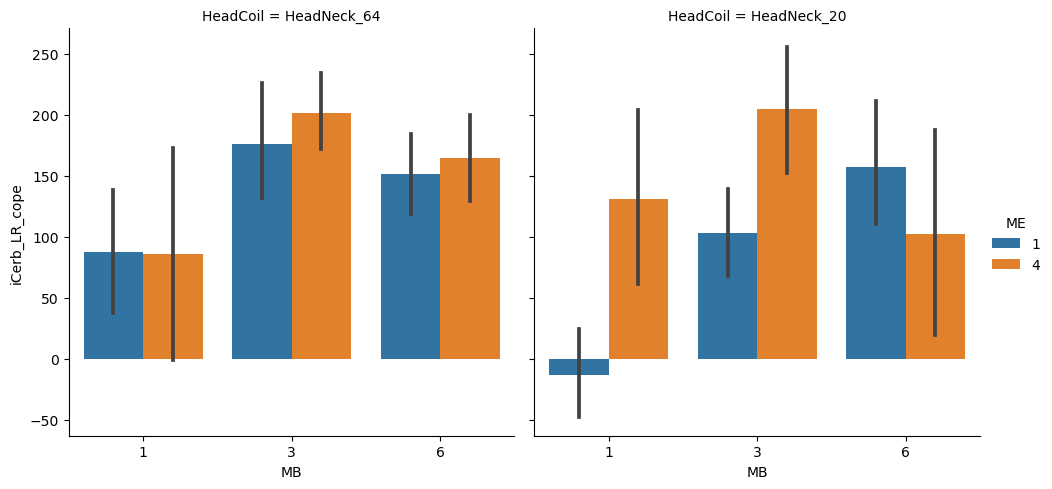

<Figure size 640x480 with 0 Axes>

In [15]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('iCerb_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('iCerb_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('iCerb_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('iCerb_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_cope.svg")
plt.show()

# print("Results for VarCope")
# res=smf.mixedlm('iCerb_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='iCerb_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_varcope.svg")
plt.show()

# SCerb-Button Activiation

In [16]:
masker= NiftiMasker(mask_img=sCerb_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(SCerb_LR_cope=copes,
               SCerb_LR_zstats=zstats,
               SCerb_LR_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [02:12<00:00,  1.43it/s]


# Display Superior Cerebellar Activation by Acquisition

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: SCerb_LR_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.2201         
Min. group size:  6       Log-Likelihood:     -99.1308       
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.232     0.185   1.254  0.210  -0.131   0.595
MB              0.152     0.042   3.668  0.000   0.071   0.234
ME              0.065     0.056   1.160  0.246  -0.045   0.174
MB:ME          -0.024     0.014  -1.656  0.098  -0.052   0.004
Group Var       0.149     0.144                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: SCerb_LR_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              36950.3144   
Min. group size:  6       Log-Likelihood:     -758.8933    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     169.121   73.769  2.293 0.022  24.536 313.706
MB             12.379   17.030  0.727 0.467 -20.999  45.756
ME             16.566   22.872  0.724 0.469 -28.263  61.395
MB:ME          -4.490    5.841 -0.769 0.442 -15.939   6.958
Group Var   18907.432   47.529                             
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: SCerb_LR_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.2708         
Min. group size:  5       Log-Likelihood:     -63.9048       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.105     0.242   0.432  0.666  -0.370   0.579
MB              0.101     0.059   1.706  0.088  -0.015   0.217
ME              0.082     0.080   1.032  0.302  -0.074   0.239
MB:ME          -0.018     0.020  -0.892  0.373  -0.058   0.022
Group Var       0.041     0.077                               
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: SCerb_LR_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              45904.7125   
Min. group size:  5       Log-Likelihood:     -451.8148    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
-----------------------------------------------------------
               Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     163.889   96.454  1.699 0.089 -25.158 352.935
MB             -3.044   24.347 -0.125 0.900 -50.764  44.675
ME             -7.244   32.778 -0.221 0.825 -71.488  57.000
MB:ME           4.440    8.373  0.530 0.596 -11.971  20.851
Group Var       0.004   17.236                             
===========================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    SCerb_LR_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.2390         
Min. group size:       5          Log-Likelihood:        -164.3428      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.103    0.240  0.427 0.669 -0.369  0.574
HeadCoil[T.HeadNeck_64]        0.130    0.304  0.427 0.670 -0.466  0.725
MB                             0.102    0.056  1.823 0.068 -0.008  0.211
MB:HeadCoil[T.HeadNeck_64]     0.051    0.071  0.722 0.470 -0.087  0.189
ME                             0.083    0.075  1.100 0.271 -0.064  0.230
ME:HeadCoil[T.HeadNeck_64]    -0.018    0.095 -0.187 0.852 -0.204  0.168
MB:ME                         -0.018    0.019 -0.959 0.338 -0.056  0.019
MB:ME:HeadCoil[T.HeadNeck_64] -0.005    0.024 -0.216 0.829 -0.053  0.042
Group Var                      0.108    0.087                           
========================================================================

"""

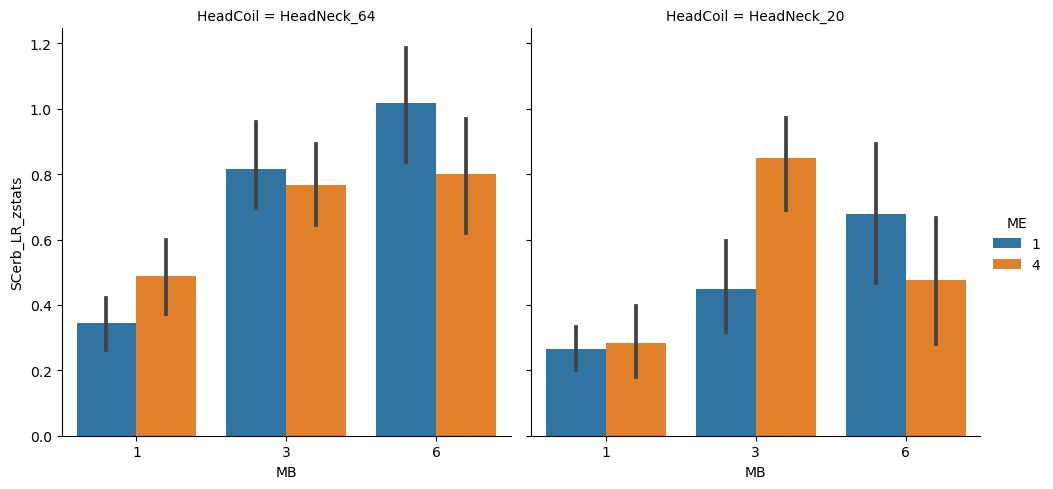

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                   MixedLM       Dependent Variable:       SCerb_LR_cope
No. Observations:        183           Method:                   REML         
No. Groups:              31            Scale:                    40417.2017   
Min. group size:         5             Log-Likelihood:           -1213.2946   
Max. group size:         6             Converged:                Yes          
Mean group size:         5.9                                                  
------------------------------------------------------------------------------
                                Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------
Intercept                       161.935   96.022  1.686 0.092  -26.264 350.134
HeadCoil[T.HeadNeck_64]           7.186  121.240  0.059 0.953 -230.440 244.812
MB                               -2.634   22.891 -0.115 0.908  -47.501  42.232
MB:HeadCoil[T.HeadNeck_64]       15.013   29.004  0.518 0.605  -41.834  71.860
ME                               -7.153   30.833 -0.232 0.817  -67.584  53.279
ME:HeadCoil[T.HeadNeck_64]       23.719   39.024  0.608 0.543  -52.768 100.205
MB:ME                             4.392    7.875  0.558 0.577  -11.042  19.826
MB:ME:HeadCoil[T.HeadNeck_64]    -8.882    9.966 -0.891 0.373  -28.416  10.651
Group Var                     11685.367   26.337                              
==============================================================================

"""

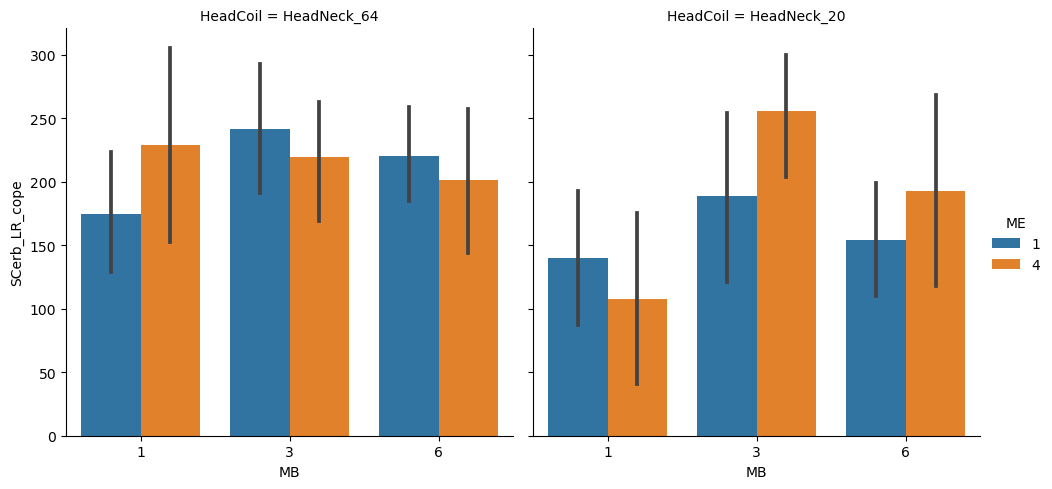

In [17]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('SCerb_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('SCerb_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('SCerb_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='SCerb_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/sCerb_LR-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('SCerb_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='SCerb_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/sCerb_LR-act_cope.svg")
plt.show()

# print("Results for VarCope")
# res=smf.mixedlm('SCerb_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='SCerb_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

#plt.savefig("../derivatives/figures/assets/sCerb_LR-act_varcope.svg")
#plt.show()

# vmPFC

In [18]:
masker= NiftiMasker(mask_img=pfc_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope15.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/tstat15.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope15.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(pfc_act_cope=copes,
               pfc_act_zstats=zstats,
               pfc_act_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [02:30<00:00,  1.26it/s]


# Display vmPFC

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: pfc_act_zstats
No. Observations: 114     Method:             REML          
No. Groups:       19      Scale:              0.4665        
Min. group size:  6       Log-Likelihood:     -131.3252     
Max. group size:  6       Converged:          Yes           
Mean group size:  6.0                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.109     0.244   0.447  0.655  -0.369   0.587
MB             0.040     0.061   0.658  0.511  -0.079   0.158
ME            -0.049     0.081  -0.603  0.546  -0.208   0.110
MB:ME          0.006     0.021   0.286  0.775  -0.035   0.047
Group Var      0.065     0.076                               
============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: pfc_act_cope
No. Observations: 114     Method:             REML        
No. Groups:       19      Scale:              50754.3913  
Min. group size:  6       Log-Likelihood:     -770.1120   
Max. group size:  6       Converged:          Yes         
Mean group size:  6.0                                     
----------------------------------------------------------
            Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept    16.891   81.048  0.208 0.835 -141.960 175.741
MB           14.323   19.959  0.718 0.473  -24.795  53.441
ME          -15.690   26.807 -0.585 0.558  -68.230  36.850
MB:ME         0.703    6.846  0.103 0.918  -12.714  14.121
Group Var  8753.494   27.848                              
==========================================================

"""

HeadNeck_20
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: pfc_act_zstats
No. Observations: 69      Method:             REML          
No. Groups:       12      Scale:              0.3202        
Min. group size:  5       Log-Likelihood:     -65.9420      
Max. group size:  6       Converged:          Yes           
Mean group size:  5.8                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      0.348     0.255   1.366  0.172  -0.151   0.848
MB            -0.019     0.064  -0.301  0.764  -0.145   0.107
ME            -0.099     0.087  -1.143  0.253  -0.269   0.071
MB:ME          0.019     0.022   0.879  0.379  -0.024   0.063
Group Var      0.000     0.052                               
============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: pfc_act_cope
No. Observations: 69      Method:             REML        
No. Groups:       12      Scale:              56190.1257  
Min. group size:  5       Log-Likelihood:     -458.3854   
Max. group size:  6       Converged:          Yes         
Mean group size:  5.8                                     
----------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept   149.668  106.765  1.402 0.161  -59.587 358.924
MB          -11.326   26.946 -0.420 0.674  -64.139  41.488
ME          -36.804   36.266 -1.015 0.310 -107.883  34.276
MB:ME         7.474    9.264  0.807 0.420  -10.684  25.632
Group Var     0.000   26.952                              
==========================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                MixedLM     Dependent Variable:     pfc_act_zstats
No. Observations:     183         Method:                 REML          
No. Groups:           31          Scale:                  0.4099        
Min. group size:      5           Log-Likelihood:         -200.0855     
Max. group size:      6           Converged:              No            
Mean group size:      5.9                                               
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.354    0.295  1.199 0.231 -0.225  0.933
HeadCoil[T.HeadNeck_64]       -0.245    0.373 -0.657 0.511 -0.976  0.486
MB                            -0.020    0.073 -0.281 0.779 -0.163  0.122
MB:HeadCoil[T.HeadNeck_64]     0.060    0.092  0.653 0.514 -0.121  0.241
ME                            -0.099    0.098 -1.013 0.311 -0.292  0.093
ME:HeadCoil[T.HeadNeck_64]     0.050    0.124  0.405 0.685 -0.193  0.294
MB:ME                          0.019    0.025  0.778 0.437 -0.030  0.069
MB:ME:HeadCoil[T.HeadNeck_64] -0.014    0.032 -0.427 0.669 -0.076  0.049
Group Var                      0.046    0.055                           
========================================================================

"""

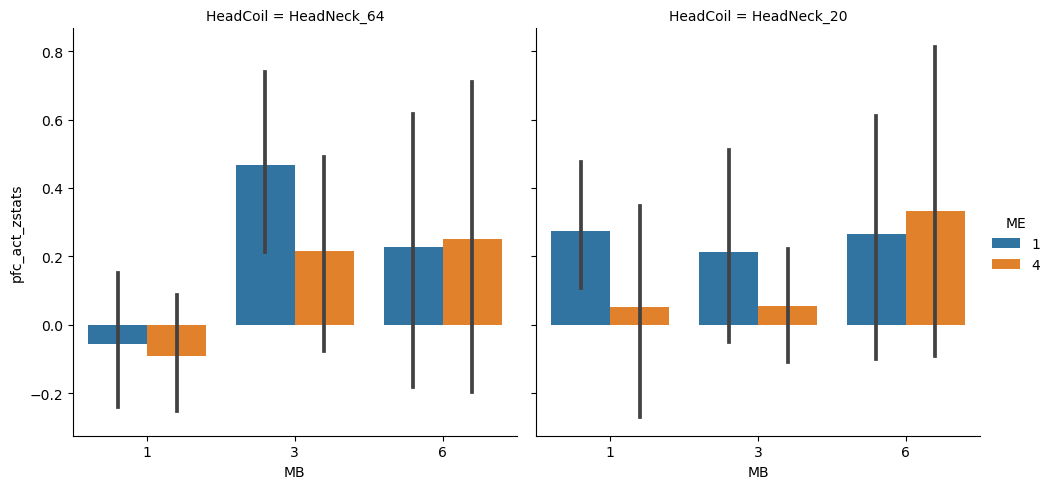

Results for Cope


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                   MixedLM       Dependent Variable:       pfc_act_cope
No. Observations:        183           Method:                   REML        
No. Groups:              31            Scale:                    51644.8141  
Min. group size:         5             Log-Likelihood:           -1230.0886  
Max. group size:         6             Converged:                No          
Mean group size:         5.9                                                 
-----------------------------------------------------------------------------
                               Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                      152.487  105.939  1.439 0.150  -55.149 360.122
HeadCoil[T.HeadNeck_64]       -135.596  133.722 -1.014 0.311 -397.685 126.494
MB                             -11.918   25.865 -0.461 0.645  -62.612  38.776
MB:HeadCoil[T.HeadNeck_64]      26.241   32.777  0.801 0.423  -38.000  90.482
ME                             -36.988   34.833 -1.062 0.288 -105.258  31.283
ME:HeadCoil[T.HeadNeck_64]      21.298   44.097  0.483 0.629  -65.130 107.725
MB:ME                            7.554    8.897  0.849 0.396   -9.883  24.991
MB:ME:HeadCoil[T.HeadNeck_64]   -6.851   11.262 -0.608 0.543  -28.924  15.223
Group Var                     8423.419   28.551                              
=============================================================================

"""

<Figure size 640x480 with 0 Axes>

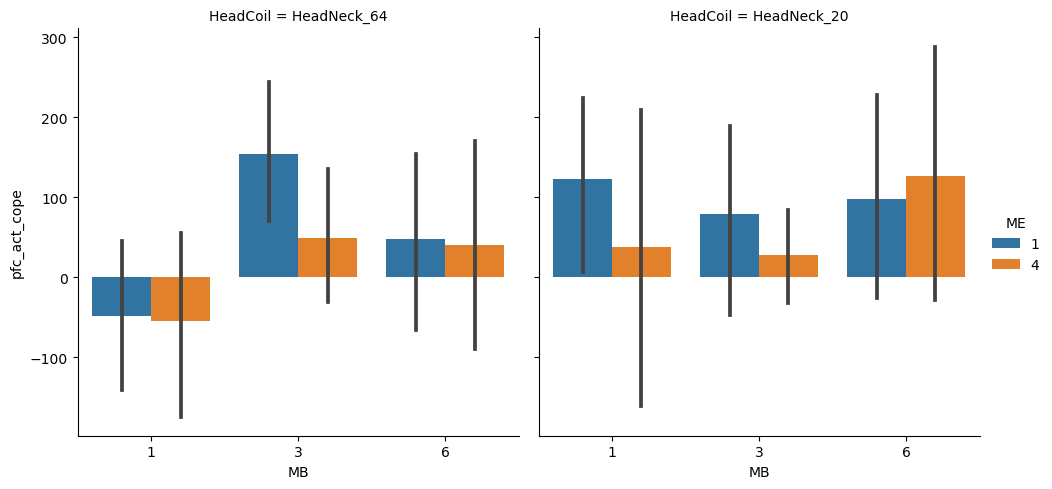

<Figure size 640x480 with 0 Axes>

In [19]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('pfc_act_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('pfc_act_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('pfc_act_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='pfc_act_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil')

plt.show()
plt.savefig("../derivatives/figures/assets/pfc_act-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('pfc_act_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='pfc_act_cope',hue='ME',col='HeadCoil',
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/pfc_act-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('pfc_act_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='pfc_act_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
#plt.show()
#plt.savefig("../derivatives/figures/assets/pfc_act-act_varcope.svg")